In [1]:
from MMT_reduce_module import *

In [2]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt

from shift_methods import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (Updated 7/6/2019): 

* Fix saturated data!
    * Examine how sky frames are being made -- **done, 7/5**
    * Examine how sky subtraction is being performed on science data -- **done, 7/5**
    * Determine best practice of aligning saturated frames -- **done, 7/6**
    * plt.imshow reduced steps -- **done, sometime**
    * Stacking size issue -- **done**
    * Update placeholder star position in saturated images from 512, 512 (before measuring companion positions)  
    
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues? -- **done, 5/23**
    * Double-check dome flat correction, now that twilight flat correction is working (with correct inputs)
    
More to-do items (last updated 7/5):
* Ensure corquad correction is applied prior to analysis steps - **done, 5/23**
* Define location for reduced data to be written -- **done, 7/1**
* Check to ensure all flatfields are taken in the same filter - update within module -- **done, 7/1**
* Rotation angle correction and image flip for MMT data (appears to be same VLT conventions) - update within module and here -- **done, 7/5**
* Make sure align flag opens ds9 with frames opening in correct order -- **done, 7/5**
* Cross-check sky subtraction in case of very saturated data, and if small changes in rotation angle make difference

## Cell to Update: Set up paths to raw data and definitions

In [3]:
# Always update and double-check the following seven paths and variables:

path_to_raw_sci = '/Volumes/Passport4TB/MinMs_Data_Testing/HIP15220_MMT_20161012/HIP15220/30.0/'
path_to_raw_darks = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/darks/'
path_to_raw_flats = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/'

objname = 'HIP15220_30s'

flattype = 0 # 0 for sky, 1 for lamp
saturated = 1 # 0 if unsaturated, 1 if saturated
alignflag = 1 # 0 if single star or faint companion, 1 if equal brightness binary or difficult to align for some reason

In [ ]:
# OK to leave these fixed for now - defined to be image center and ARIES detector size
ref_imagex = 512
ref_imagey =  512
imsize = 1024

## The following cells are each of the steps of the reduce_raw_sci function

In [4]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'q*.fits')

print(f"Number of science frames found: {len(scilist)} \n")

Number of science frames found: 20 



In [5]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 30.0



In [6]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

In [7]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0


for ii in range(0, n):
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)

    # flip image left-right, as required for MMT data:
    im = np.fliplr(im)

    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)    





In [8]:
print(angle)
print(im)

[-2.67016115 -2.67509203 -2.67999416 -2.6848293  -2.69364029 -2.69861163
 -2.70345599 -2.7084576  -2.7174705  -2.72239678 -2.72735092 -2.73240842
 -2.73996454 -2.74501088 -2.75012694 -2.75538778 -2.76256134 -2.76777291
 -2.7728964  -2.77796038]
[[1103.3036   1092.8668   1109.5034   ... 1211.3641   1321.2272
     0.      ]
 [1171.6167   1085.3861   1097.1403   ... 1205.7192   1237.2284
   102.82932 ]
 [1164.7964   1189.0614   1135.9736   ... 1104.4445   1078.2921
   101.557945]
 ...
 [1840.3394   1408.9786   1323.9059   ... 1279.7633   1225.593
   101.51207 ]
 [2239.247    1556.5284   1303.9866   ... 1259.0709   1206.0144
   103.446556]
 [2360.8423   1883.707    1479.2645   ... 1259.7395   1097.8823
   107.99958 ]]


Creating and applying master darks and flats...

Found 16 darks with exposure times of 30.0. 



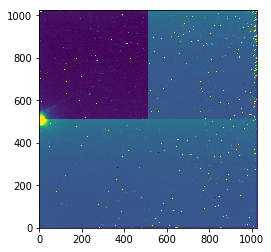

In [9]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_sci, path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax, origin='lower')

In [10]:
# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


In [11]:
flatlist = glob.glob(path_to_raw_flats + '**/q*fits',recursive = True)

Found 51 total flats taken in Ks band filter.

Found 51 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 



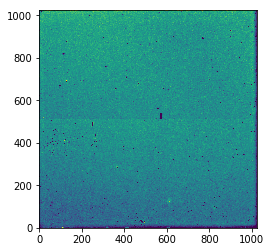

In [12]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_sci, path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax, origin='lower')

In [13]:
# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat



Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



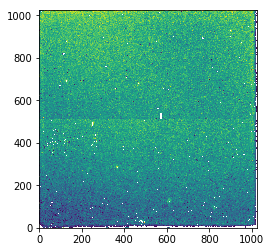

In [14]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(path_to_raw_sci, med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax, origin='lower')

In [15]:
# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)


Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19


In [16]:
# write out a test reduced science image 
fits.writeto(path_to_raw_sci+'test_reduced_science.fits', reduced_sciarray[:,:,0], overwrite=True)

In [17]:
#MASTER_SKY
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(path_to_raw_sci, reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



1576.4052791009663


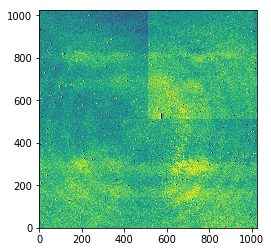

In [18]:
# get median and examine sky output:
print(np.median(sky_output[1]))
vmin, vmax = interval.get_limits(sky_output[1])
plt.imshow(sky_output[1], vmin=vmin, vmax=vmax, origin='lower')

In [19]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [20]:
#INDIVIDUAL_REDUCED_SCI_IMAGES
t0=time.time()

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(path_to_raw_sci+sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
    
t1=time.time()
print("Time taken: ", (t1-t0)/60.)

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4
Saving reduced frame #5
Saving reduced frame #6
Saving reduced frame #7
Saving reduced frame #8
Saving reduced frame #9
Saving reduced frame #10
Saving reduced frame #11
Saving reduced frame #12
Saving reduced frame #13
Saving reduced frame #14
Saving reduced frame #15
Saving reduced frame #16
Saving reduced frame #17
Saving reduced frame #18
Saving reduced frame #19
Time taken:  0.03209946552912394


## Measure Star Centers

In [21]:
# get directory where reduced frames are written
current_dir = path_to_raw_sci

# measure star positions in all of the images
if saturated == 0:
    xcen, ycen = measure_star_centers(path_to_raw_sci, skysub_science_array, scinames_list, sciheader, saturated, alignflag, current_dir, saveframes = True)

elif saturated == 1:    
    xcen, ycen = cross_correlate_centers(path_to_raw_sci, skysub_science_array, scinames_list, ref_imagex, ref_imagey)    

else:
    raiseException("Saturated flag not recognized.")

0.0 0.0
Overwriting existing science frames with star position values: reducedsci_000.fits
11.312736595783917 -5.710808410393838
Overwriting existing science frames with star position values: reducedsci_001.fits
5.1169909846489645 -33.791299157494564
Overwriting existing science frames with star position values: reducedsci_002.fits
-11.079771324687954 -21.81709144232724
Overwriting existing science frames with star position values: reducedsci_003.fits
-248.71669971365748 112.13972446970035
Overwriting existing science frames with star position values: reducedsci_004.fits
-232.66559252486098 98.33768273464602
Overwriting existing science frames with star position values: reducedsci_005.fits
-243.77618919385765 73.03110877822326
Overwriting existing science frames with star position values: reducedsci_006.fits
-259.9914811455805 84.99055298215944
Overwriting existing science frames with star position values: reducedsci_007.fits
-226.27635124998682 -375.69505752422674
Overwriting existing

In [22]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [512.         500.6872634  506.88300902 523.07977132 760.71669971
 744.66559252 755.77618919 771.99148115 738.27635125 714.09532758
 727.38022138 746.90906661 258.5145815  241.5802193  244.85681581
 277.24281536 291.12881608 268.03157646 282.49561417 299.49208037] ycen: [512.         517.71080841 545.79129916 533.81709144 399.86027553
 413.66231727 438.96889122 427.00944702 887.69505752 903.02765573
 921.61699228 915.76499452 872.94110553 873.72315813 891.10480606
 887.65671203 370.96834008 380.94384032 403.91318842 395.95640115]


In [23]:
#SHIFTED_IMAGES
#STACKED
#FINAL

# get current directory where reduced frames are written
current_dir = path_to_raw_sci

t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(path_to_raw_sci, xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")

2017 2016
Shifting image 0 of 20...
Shifting image 1 of 20...
Shifting image 2 of 20...
Shifting image 3 of 20...
Shifting image 4 of 20...
Shifting image 5 of 20...
Shifting image 6 of 20...
Shifting image 7 of 20...
Shifting image 8 of 20...
Shifting image 9 of 20...
Shifting image 10 of 20...
Shifting image 11 of 20...
Shifting image 12 of 20...
Shifting image 13 of 20...
Shifting image 14 of 20...
Shifting image 15 of 20...
Shifting image 16 of 20...
Shifting image 17 of 20...
Shifting image 18 of 20...
Shifting image 19 of 20...
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: MWRFITS.
% Compiled module: FXADDPAR.
% Compiled module: SXDELPAR.
Completed reduction of 20 images in 0.5329405466715494 minutes.









## Run all of the above reduction steps in one go:

In [24]:
#Running all the above reduction steps in one go
reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, ref_imagex, ref_imagey, imsize = 1024)

Number of science frames found: 20 

Science frame exposure time: 30.0

Creating and applying master darks and flats...

Found 16 darks with exposure times of 30.0. 

Found 51 total flats taken in Ks band filter.

Found 51 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 

Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 

Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Creating master sky from science frames...

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Sa